# Numbers Summation (using RNN LSTM)

> - 🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - ▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments)

## Experiment overview

In this experiment we will use [Recurrent Neural Network](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNN) to sum up two numbers (each number is in a range of `[1, 99]`). The summation expression (i.e. `"1+45"` or `37+68`) that will be sent to the RNN _input_ will be treated as a **string** (sequence of characters) and the _output_ of the RNN will also be a string (i.e. `"46"` or `"106"`) - the sequence of characters that will represent the result of summation. This is a "sequence-to-sequence" version of RNN implementation. We will use LSTM ([Long Short-Term Memory](https://en.wikipedia.org/wiki/Long_short-term_memory)) recurent neural network for this task.

For this experiment we will use [Tensorflow v2](https://www.tensorflow.org/) with its [Keras API](https://www.tensorflow.org/guide/keras).

![numbers_summation_rnn.png](../../demos/src/images/numbers_summation_rnn.png)

Inspired by [Learn to Add Numbers with an Encoder-Decoder LSTM Recurrent Neural Network](https://machinelearningmastery.com/learn-add-numbers-seq2seq-recurrent-neural-networks/) article.

## Import dependencies

In [1]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import random
import math
import datetime

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


## Configuring Tensorboard

We will use [Tensorboard](https://www.tensorflow.org/tensorboard) to debug the model later.

In [3]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

## Generate a dataset

In order to train a neural network we need to generate a training dataset which will consist of examples `x` (set of summation expressions) and labels `y` (set of correct answers for each expression). We will start with generating a set of _numbers_ (not strings so far) and than we will convert the sets of numbers into _strings_.

In [4]:
dataset_size = 5000
sequence_length = 2
max_num = 100

In [5]:
# Generates summation sequences and summation results in form of vector if numbers.
def generate_sums(dataset_size, sequence_length, max_num):
    # Initial dataset states.
    x, y = [], []
    
    # Generating sums.
    for i in range(dataset_size):
        sequence = [random.randint(1, max_num) for _ in range(sequence_length)]
        x.append(sequence)
        y.append(sum(sequence))
    
    return x, y

In [6]:
x_train, y_train = generate_sums(
    dataset_size=dataset_size,
    sequence_length=sequence_length,
    max_num=max_num
)

print('x_train:\n', x_train[:3])
print()
print('y_train:\n', y_train[:3])

x_train:
 [[8, 79], [36, 39], [47, 15]]

y_train:
 [87, 75, 62]


Recurrent neural networks are normally deals with the sequences (of one or many elements) on the input. In order to treat a summation expression as a sequence we will convert array of numbers (i.e. `[[13, 8], [85, 91], ...]`) into strings (i.e. `['13+8   ', '85+91  ', ...]`). We also want to add a space `" "` paddings to each string to make them all of the same length. After doing that we will be able to feed our RNN character by character (i.e. `1`, then `3`, then `+`, then `8`, then ` ` and so on).

In [7]:
# Convert array of numbers for x and y into strings.
# Also it adds a space (" ") padding to strings to make them of the same length. 
def dataset_to_strings(x, y, max_num):
    # Initial dataset states.
    x_str, y_str = [], []
    
    sequnce_length = len(x[0])
    
    # Calculate the maximum length of equation (x) string (i.e. of "11+99")
    num_of_pluses = sequnce_length - 1
    num_of_chars_per_digit = math.ceil(math.log10(max_num + 1))
    max_x_length = sequnce_length * num_of_chars_per_digit + num_of_pluses
    
    # Calculate the maximum length of label (y) string (i.e. of "167")
    max_y_length = math.ceil(math.log10(sequnce_length * (max_num + 1)))
    
    # Add a space " " padding to equation strings to make them of the same length.
    for example in x:
        str_example = '+'.join([str(digit) for digit in example])
        str_example += ''.join([' ' for padding in range(max_x_length - len(str_example))])
        x_str.append(str_example)
    
    # Add a space " " padding to labels strings to make them of the same length.
    for label in y:
        str_example = str(label)
        str_example += ''.join([' ' for padding in range(max_y_length - len(str_example))])
        y_str.append(str_example)
    
    return x_str, y_str

In [8]:
x_train_str, y_train_str = dataset_to_strings(x_train, y_train, max_num)

print('x_train_str:\n', np.array(x_train_str[:3]))
print()
print('y_train_str:\n', np.array(y_train_str[:3]))

x_train_str:
 ['8+79   ' '36+39  ' '47+15  ']

y_train_str:
 ['87 ' '75 ' '62 ']


In [9]:
# Since we allow only numbers, plus sign and spaces the vocabulary looks pretty simple.
vocabulary = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', ' ']

In [10]:
# Python dictionary that will convert a character to its index in the vocabulary.
char_to_index = {char: index for index, char in enumerate(vocabulary)}

print(char_to_index)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, ' ': 11}


Our RNN need to have a digits as an input to operate with (and not a strings). To convert summation expressions strings into number the first step we will do is to convert each character of each string into the position index of this character in the `vocabulary`.

In [11]:
# Converts x and y arrays of strings into array of char indices.
def dataset_to_indices(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    char_to_index = {char: index for index, char in enumerate(vocabulary)}
    
    for example in x:
        example_encoded = [char_to_index[char] for char in example]
        x_encoded.append(example_encoded)
        
    for label in y:
        label_encoded = [char_to_index[char] for char in label]
        y_encoded.append(label_encoded)
        
    return x_encoded, y_encoded

In [12]:
x_train_encoded, y_train_encoded = dataset_to_indices(
    x_train_str,
    y_train_str,
    vocabulary
)

print('x_train_encoded:\n', np.array(x_train_encoded[:3]))
print()
print('y_train_encoded:\n', np.array(y_train_encoded[:3]))

x_train_encoded:
 [[ 8 10  7  9 11 11 11]
 [ 3  6 10  3  9 11 11]
 [ 4  7 10  1  5 11 11]]

y_train_encoded:
 [[ 8  7 11]
 [ 7  5 11]
 [ 6  2 11]]


To make our dataset even more understandable for our recurrent neural network we will convert each number into `0/1` [one-hot vector](https://en.wikipedia.org/wiki/One-hot) (i.e. number `1` will be transformed into array `[0 1 0 0 0 0 0 0 0 0 0 0]`).

In [13]:
# Convert x and y sets of numbers into one-hot vectors.
def dataset_to_one_hot(x, y, vocabulary):
    x_encoded, y_encoded = [], []
    
    for example in x:
        pattern = []
        for index in example:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        x_encoded.append(pattern)
            
    for label in y:
        pattern = []
        for index in label:
            vector = [0 for _ in range(len(vocabulary))]
            vector[index] = 1
            pattern.append(vector)
        y_encoded.append(pattern)
        
    return x_encoded, y_encoded

In [14]:
x_train_one_hot, y_train_one_hot = dataset_to_one_hot(
    x_train_encoded,
    y_train_encoded,
    vocabulary
)

print('x_train_one_hot:\n', np.array(x_train_one_hot[:1]))
print()
print('y_train_one_hot:\n', np.array(y_train_one_hot[:1]))

x_train_one_hot:
 [[[0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_train_one_hot:
 [[[0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]


Now we may combine all the function together and create a one function that will do all the work to generate a dataset in the proper format for us.

In [15]:
# Generates a dataset.
def generate_dataset(dataset_size, sequence_length, max_num, vocabulary):
    # Generate integet sum sequences.
    x, y = generate_sums(dataset_size, sequence_length, max_num)
    # Convert integer sum sequences into strings.
    x, y = dataset_to_strings(x, y, max_num)
    # Encode each character to a char indices.
    x, y = dataset_to_indices(x, y, vocabulary)
    # Encode each index into one-hot vector.
    x, y = dataset_to_one_hot(x, y, vocabulary)
    # Return the data.
    return np.array(x), np.array(y)

In [16]:
x, y = generate_dataset(
    dataset_size,
    sequence_length,
    max_num,
    vocabulary
)

print('x:\n', x[:1])
print()
print('y:\n', y[:1])

x:
 [[[0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 0 1 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 1 0 0 0 0]]]


In [17]:
print('x.shape: ', x.shape) # (input_sequences_num, input_sequence_length, supported_symbols_num)
print('y.shape: ', y.shape) # (output_sequences_num, output_sequence_length, supported_symbols_num)

x.shape:  (5000, 7, 12)
y.shape:  (5000, 3, 12)


In [18]:
# How many characters each summation expression has.
input_sequence_length = x.shape[1]

# How many characters the output sequence of the RNN has.
output_sequence_length = y.shape[1]

# The length of one-hot vector for each character in the input (should be the same as vocabulary_size).
supported_symbols_num = x.shape[2]

# The number of different characters our RNN network could work with (i.e. it understands only digits, "+" and " ").
vocabulary_size = len(vocabulary)

print('input_sequence_length: ', input_sequence_length)
print('output_sequence_length: ', output_sequence_length)
print('supported_symbols_num: ', supported_symbols_num)
print('vocabulary_size: ', vocabulary_size)

input_sequence_length:  7
output_sequence_length:  3
supported_symbols_num:  12
vocabulary_size:  12


In [19]:
# Converts a sequence (array) of one-hot encoded vectors back into the string based on the provided vocabulary.
def decode(sequence, vocabulary):
    index_to_char = {index: char for index, char in enumerate(vocabulary)}
    strings = []
    for char_vector in sequence:
        char = index_to_char[np.argmax(char_vector)]
        strings.append(char)
    return ''.join(strings)

In [20]:
decode(y[0], vocabulary)

'187'

## Build a model

We will use a [Sequential] TensorFlow model with [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Logically our model will consist of **encoder** and **decoder**. _Encoder_ will encode the input expression into an array of numbers. And then _decoder_ will try to build an output result sequence by decoding the array of numbers from encoder.

In [21]:
epochs_num = 200
batch_size = 128

In [22]:
model = tf.keras.models.Sequential()

# Encoder
# -------

model.add(tf.keras.layers.LSTM(
    units=128,
    input_shape=(input_sequence_length, vocabulary_size),
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

# Decoder
# -------

# We need this layer to match the encoder output shape with decoder input shape.
# Encoder outputs ONE vector of numbers but for decoder we need have output_sequence_length vectors.
model.add(tf.keras.layers.RepeatVector(
    n=output_sequence_length,
))

model.add(tf.keras.layers.LSTM(
    units=128,
    return_sequences=True,
    recurrent_initializer=tf.keras.initializers.GlorotNormal()
))

model.add(tf.keras.layers.TimeDistributed(
    layer=tf.keras.layers.Dense(
        units=vocabulary_size,
    )
))

model.add(tf.keras.layers.Activation(
    activation='softmax'
))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 3, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 3, 12)             1548      
_________________________________________________________________
activation (Activation)      (None, 3, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


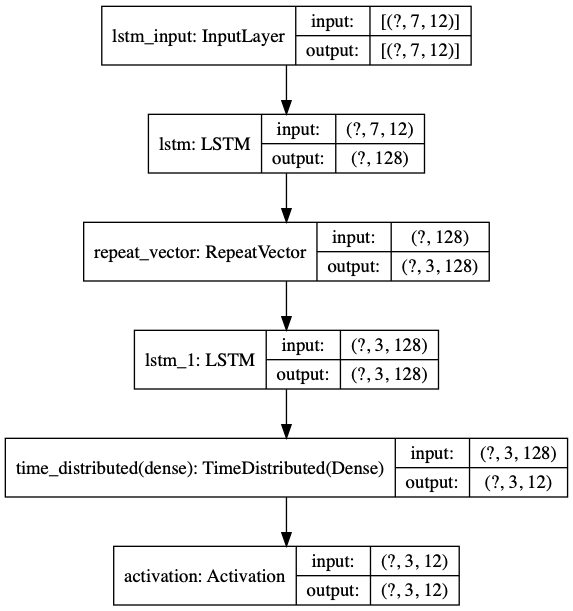

In [24]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

## Train a model

In [27]:
log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'],
)

In [31]:
history = model.fit(
    x=x,
    y=y,
    epochs=epochs_num,
    batch_size=batch_size,
    validation_split=0.1,
    callbacks=[tensorboard_callback]
)

Train on 4500 samples, validate on 500 samples
Epoch 1/200
4500/4500 [==============================] - 5s 1ms/sample - loss: 2.3158 - accuracy: 0.2441 - val_loss: 2.1193 - val_accuracy: 0.3800
Epoch 2/200
4500/4500 [==============================] - 1s 275us/sample - loss: 1.9693 - accuracy: 0.3836 - val_loss: 1.9278 - val_accuracy: 0.3827
Epoch 3/200
4500/4500 [==============================] - 2s 400us/sample - loss: 1.8441 - accuracy: 0.3830 - val_loss: 1.7944 - val_accuracy: 0.3900
Epoch 4/200
4500/4500 [==============================] - 2s 505us/sample - loss: 1.7833 - accuracy: 0.3804 - val_loss: 1.7343 - val_accuracy: 0.3880
Epoch 5/200
4500/4500 [==============================] - 1s 279us/sample - loss: 1.7441 - accuracy: 0.3870 - val_loss: 1.7016 - val_accuracy: 0.4013
Epoch 6/200
4500/4500 [==============================] - 1s 282us/sample - loss: 1.7044 - accuracy: 0.3932 - val_loss: 1.6716 - val_accuracy: 0.4080
Epoch 7/200
4500/4500 [==============================] - 1s 2

4500/4500 [==============================] - 2s 361us/sample - loss: 0.0205 - accuracy: 0.9994 - val_loss: 0.0359 - val_accuracy: 0.9947
Epoch 110/200
4500/4500 [==============================] - 1s 261us/sample - loss: 0.0190 - accuracy: 0.9999 - val_loss: 0.0359 - val_accuracy: 0.9947
Epoch 111/200
4500/4500 [==============================] - 1s 264us/sample - loss: 0.0185 - accuracy: 0.9999 - val_loss: 0.0347 - val_accuracy: 0.9947
Epoch 112/200
4500/4500 [==============================] - 1s 255us/sample - loss: 0.0183 - accuracy: 0.9996 - val_loss: 0.0343 - val_accuracy: 0.9953
Epoch 113/200
4500/4500 [==============================] - 1s 279us/sample - loss: 0.0177 - accuracy: 0.9997 - val_loss: 0.0352 - val_accuracy: 0.9953
Epoch 114/200
4500/4500 [==============================] - 2s 344us/sample - loss: 0.0168 - accuracy: 0.9999 - val_loss: 0.0322 - val_accuracy: 0.9947
Epoch 115/200
4500/4500 [==============================] - 1s 315us/sample - loss: 0.0161 - accuracy: 0.9998

In [32]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

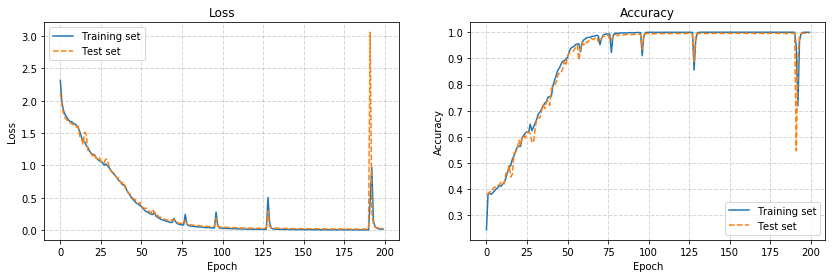

In [33]:
render_training_history(history)

## Test a dataset

In [34]:
x_test, y_test = generate_dataset(dataset_size, sequence_length, max_num, vocabulary)

print('x_test:\n', x_test[:1])
print()
print('y_test:\n', y_test[:1])

x_test:
 [[[0 0 0 0 0 0 0 1 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 1]]]

y_test:
 [[[0 1 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0]]]


In [35]:
predictions = model.predict(x_test)

print('predictions.shape: ', predictions.shape)
print()
print('predictions[0]:\n', predictions[0])
print()
print('predictions[1]:\n', predictions[1])

predictions.shape:  (5000, 3, 12)

predictions[0]:
 [[1.56478808e-09 9.99993443e-01 1.13263614e-10 2.43536555e-13
  7.35255086e-12 1.87883997e-11 2.41102582e-10 4.59983891e-11
  1.34911238e-08 6.54733321e-06 8.69514460e-11 4.95329960e-13]
 [4.08798002e-07 2.92953946e-08 1.33197474e-07 7.34924754e-07
  1.59472929e-05 1.65897664e-02 9.81849730e-01 1.47053797e-03
  6.89475419e-05 3.72986460e-06 1.31091102e-08 1.40613343e-09]
 [9.87638593e-01 4.40192549e-03 1.97818463e-06 6.63003252e-09
  4.55207649e-09 9.64273106e-11 2.73215264e-08 1.80779409e-07
  1.56410679e-05 7.94167537e-03 1.62981628e-08 4.15896695e-09]]

predictions[1]:
 [[2.15935381e-09 9.99992371e-01 5.40815170e-09 6.49596765e-11
  9.35228422e-11 9.23694662e-11 2.05900808e-09 8.82467655e-10
  5.42079519e-08 7.62533909e-06 2.06515055e-10 2.99114275e-11]
 [3.79572568e-10 6.81736542e-11 2.66999258e-08 2.08649180e-06
  1.04209560e-03 9.93228376e-01 5.15519409e-03 5.40546724e-04
  3.17595914e-05 1.57793056e-09 1.10365084e-09 2.60308664

In [36]:
x_encoded = [decode(example, vocabulary) for example in x_test]
y_expected = [decode(label, vocabulary) for label in y_test]
y_predicted = [decode(prediction, vocabulary) for prediction in predictions]

explore_num = 40
for example, label, prediction in list(zip(x_encoded, y_expected, y_predicted))[:explore_num]:
    checkmark = '✓' if label == prediction else ''
    print('{} = {} [predict: {}] {}'.format(example, label, prediction, checkmark))

76+84   = 160 [predict: 160] ✓
58+99   = 157 [predict: 157] ✓
36+84   = 120 [predict: 120] ✓
62+45   = 107 [predict: 107] ✓
45+66   = 111 [predict: 111] ✓
9+93    = 102 [predict: 102] ✓
62+39   = 101 [predict: 101] ✓
67+11   = 78  [predict: 78 ] ✓
61+15   = 76  [predict: 76 ] ✓
89+40   = 129 [predict: 129] ✓
81+21   = 102 [predict: 102] ✓
13+50   = 63  [predict: 63 ] ✓
48+7    = 55  [predict: 55 ] ✓
47+37   = 84  [predict: 84 ] ✓
9+29    = 38  [predict: 38 ] ✓
55+52   = 107 [predict: 107] ✓
35+75   = 110 [predict: 110] ✓
64+21   = 85  [predict: 85 ] ✓
31+14   = 45  [predict: 45 ] ✓
11+89   = 100 [predict: 100] ✓
18+66   = 84  [predict: 84 ] ✓
31+51   = 82  [predict: 82 ] ✓
9+51    = 60  [predict: 60 ] ✓
37+3    = 40  [predict: 40 ] ✓
92+89   = 181 [predict: 181] ✓
7+39    = 46  [predict: 46 ] ✓
14+73   = 87  [predict: 87 ] ✓
15+47   = 62  [predict: 62 ] ✓
34+23   = 57  [predict: 57 ] ✓
17+26   = 43  [predict: 43 ] ✓
83+10   = 93  [predict: 93 ] ✓
66+96   = 162 [predict: 162] ✓
56+71   

## Debugging the model with TensorBoard

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [37]:
%tensorboard --logdir .logs/fit

## Save a model

In [47]:
model_name = 'numbers_summation_rnn.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/numbers_summation_rnn/numbers_summation_rnn.h5 \
  ./demos/public/models/numbers_summation_rnn
```

You may find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.